# Install/upgrading/loading modules, will vary depending on your system

In [1]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 43.2 MB/s 
     |████████████████████████████████| 895 kB 46.3 MB/s 
     |████████████████████████████████| 596 kB 44.6 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install --upgrade gensim
!pip install --upgrade spacy

     |████████████████████████████████| 24.1 MB 56.0 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 10.1 MB 31.1 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 451 kB 47.4 MB/s 
     |████████████████████████████████| 181 kB 48.6 MB/s 
     |████████████████████████████████| 628 kB 45.5 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninsta

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
import gensim
import gensim.downloader
import tensorflow as tf
import tensorflow_hub
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers, optimizers
from keras.layers import Embedding, Dense, Dropout, Input, LSTM, Bidirectional, TextVectorization, BatchNormalization
from keras.models import Sequential
from keras.initializers import Constant
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend
from transformers import TFBertModel, TFBertForSequenceClassification, BertTokenizer, BertConfig, DistilBertModel, DistilBertConfig, TFDistilBertForSequenceClassification, DistilBertTokenizer, TFDistilBertModel

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 777.4 MB 6.7 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [16]:
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# **LSTM**

## Preprocessing, skip if already done in the Baseline notebook

In [ ]:
train_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/train.csv')
train_raw.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [ ]:
train_full = train_raw.drop(['review_id', 'year'], axis=1)

In [ ]:
nlp = spacy.load("en_core_web_lg", exclude=["parser", "ner"])

def preprocess(text):
    # TODO: Replace the next line with your own code.
    doc = nlp(text)
    res = ""
    for token in doc:
        if token.is_stop != True and token.is_alpha == True:
            res = res + " " + token.text.lower()
    return res

train_full['ur_prep'] = 'na'
train_full['ur_prep'] = train_full['user_review'].apply(preprocess)

In [ ]:
train_full.head()

,title,user_review,user_suggestion,ur_prep
0,Spooky's Jump Scare Mansion,I'm scared and hearing creepy voices. So I'll...,1,scared hearing creepy voices pause moment wri...
1,Spooky's Jump Scare Mansion,"Best game, more better than Sam Pepper's YouTu...",1,best game better sam pepper youtube account n...
2,Spooky's Jump Scare Mansion,"A littly iffy on the controls, but once you kn...",1,littly iffy controls know play easy master fl...
3,Spooky's Jump Scare Mansion,"Great game, fun and colorful and all that.A si...",1,great game fun colorful note getting windowed...
4,Spooky's Jump Scare Mansion,Not many games have the cute tag right next to...,1,games cute tag right horror tag steam played ...


In [ ]:
max_len = 0
rlength = []
for i in range(train_full.shape[0]):
    length = len(train_full.ur_prep[i].split())
    rlength.append(length)
    if length > max_len:
        max_len = length

top_5_idx = np.argsort(rlength)[-5:]
train_full = train_full.drop(top_5_idx, axis=0)
train_full = train_full.reset_index()

In [ ]:
# Splitting the data
df_train, df_val = train_test_split(train_full, test_size=0.3)
df_val, df_test = train_test_split(df_val, test_size=0.5)

In [ ]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [ ]:
train_full.to_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/train_full.csv')
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/df_train.csv')
df_val.to_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/df_val.csv')
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/df_test.csv')

## Load the data, skip if preprocessing done in this notebook

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/df_train.csv')
df_balanced = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/df_balanced.csv')
df_val = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/df_val.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TextMining/df_test.csv')

In [6]:
df_train.dropna(subset = ["ur_prep"], inplace=True)
df_val.dropna(subset = ["ur_prep"], inplace=True)
df_test.dropna(subset = ["ur_prep"], inplace=True)

## Set up the tokenizer and use it to encode the three data sets

In [7]:
t = Tokenizer()
t.fit_on_texts(df_balanced.ur_prep)
vocab_size = len(t.word_index) + 1
encoded_docs = t.texts_to_sequences(df_balanced.ur_prep)

In [8]:
max_len=698
padded_docs = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
labels = df_balanced.user_suggestion

encoded_docs_val = t.texts_to_sequences(df_val.ur_prep)
padded_docs_val = pad_sequences(encoded_docs_val, maxlen=max_len, padding='post')
labels_val = df_val.user_suggestion

encoded_docs_test = t.texts_to_sequences(df_test.ur_prep)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding='post')
labels_test = df_test.user_suggestion

## Load glove fectors and set up embedding matrix, skip if loading file

In [ ]:
glove_vectors = gensim.downloader.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
embedding_matrix = np.zeros((vocab_size, 200))
for word, i in t.word_index.items():
    if word in glove_vectors.key_to_index:
        embedding_matrix[i] = glove_vectors[word]

In [ ]:
np.savetxt('/content/drive/MyDrive/Colab Notebooks/TextMining/glove_twitter_200_balanced.csv', embedding_matrix, delimiter=',')

## Load embedding matrix from file if available

In [9]:
embedding_matrix = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/TextMining/glove_twitter_200_balanced.csv', delimiter=',', dtype='float32')

In [10]:
print(vocab_size)
print(embedding_matrix.shape)

38714
(38714, 200)


## Setting up and fitting LSTM model, skip if loading model from file

### Design, visualize and compile the model

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.6))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 698, 200)          7742800   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

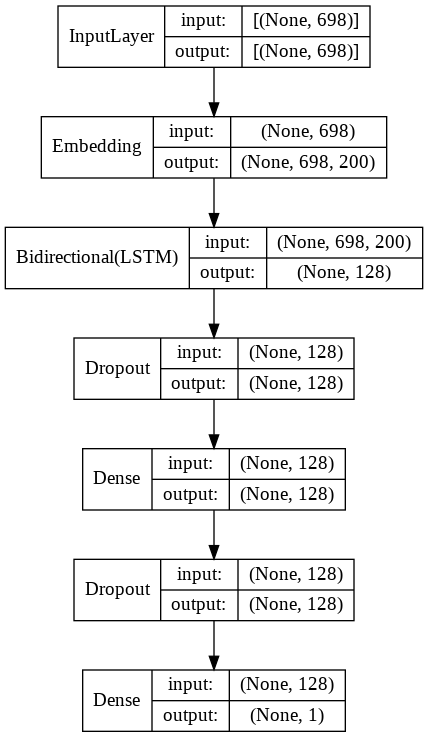

In [12]:
from keras.utils.vis_utils import plot_model
model.summary()
tf.keras.utils.plot_model(model, to_file='/content/drive/MyDrive/Colab Notebooks/TextMining/model_plot.png', 
           show_shapes=True, 
           show_layer_names=False)

In [13]:
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])

### Fit the LSTM model and plot history

In [14]:
history = model.fit(padded_docs, labels, 
                    batch_size=256, epochs=40, 
                    validation_data=(padded_docs_val, labels_val), 
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1), 
                               ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)])

Epoch 1/40
55/55 [==============================] - ETA: 0s - loss: 0.6219 - accuracy: 0.6436
Epoch 00001: val_accuracy improved from -inf to 0.74026, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


55/55 [==============================] - 48s 725ms/step - loss: 0.6219 - accuracy: 0.6436 - val_loss: 0.5326 - val_accuracy: 0.7403
Epoch 2/40
55/55 [==============================] - ETA: 0s - loss: 0.4970 - accuracy: 0.7745
Epoch 00002: val_accuracy improved from 0.74026 to 0.77502, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


55/55 [==============================] - 37s 681ms/step - loss: 0.4970 - accuracy: 0.7745 - val_loss: 0.4663 - val_accuracy: 0.7750
Epoch 3/40
55/55 [==============================] - ETA: 0s - loss: 0.4544 - accuracy: 0.7993
Epoch 00003: val_accuracy improved from 0.77502 to 0.78380, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


55/55 [==============================] - 37s 677ms/step - loss: 0.4544 - accuracy: 0.7993 - val_loss: 0.4560 - val_accuracy: 0.7838
Epoch 4/40
55/55 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8110
Epoch 00004: val_accuracy did not improve from 0.78380
55/55 [==============================] - 17s 300ms/step - loss: 0.4325 - accuracy: 0.8110 - val_loss: 0.4635 - val_accuracy: 0.7834
Epoch 5/40
55/55 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8128
Epoch 00005: val_accuracy improved from 0.78380 to 0.80596, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


55/55 [==============================] - 38s 695ms/step - loss: 0.4209 - accuracy: 0.8128 - val_loss: 0.4260 - val_accuracy: 0.8060
Epoch 6/40
55/55 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.8291
Epoch 00006: val_accuracy improved from 0.80596 to 0.81016, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


55/55 [==============================] - 37s 687ms/step - loss: 0.3923 - accuracy: 0.8291 - val_loss: 0.4034 - val_accuracy: 0.8102
Epoch 7/40
55/55 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8394
Epoch 00007: val_accuracy did not improve from 0.81016
55/55 [==============================] - 17s 301ms/step - loss: 0.3764 - accuracy: 0.8394 - val_loss: 0.4557 - val_accuracy: 0.7857
Epoch 8/40
55/55 [==============================] - ETA: 0s - loss: 0.3622 - accuracy: 0.8446
Epoch 00008: val_accuracy did not improve from 0.81016
55/55 [==============================] - 16s 299ms/step - loss: 0.3622 - accuracy: 0.8446 - val_loss: 0.4342 - val_accuracy: 0.7941
Epoch 9/40
55/55 [==============================] - ETA: 0s - loss: 0.3513 - accuracy: 0.8532
Epoch 00009: val_accuracy improved from 0.81016 to 0.82926, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm/assets


55/55 [==============================] - 37s 683ms/step - loss: 0.3513 - accuracy: 0.8532 - val_loss: 0.3931 - val_accuracy: 0.8293
Epoch 10/40
55/55 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8605
Epoch 00010: val_accuracy did not improve from 0.82926
55/55 [==============================] - 17s 299ms/step - loss: 0.3312 - accuracy: 0.8605 - val_loss: 0.4021 - val_accuracy: 0.8163
Epoch 11/40
55/55 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8660
Epoch 00011: val_accuracy did not improve from 0.82926
55/55 [==============================] - 16s 299ms/step - loss: 0.3203 - accuracy: 0.8660 - val_loss: 0.3937 - val_accuracy: 0.8228
Epoch 12/40
55/55 [==============================] - ETA: 0s - loss: 0.3013 - accuracy: 0.8784
Epoch 00012: val_accuracy did not improve from 0.82926
55/55 [==============================] - 16s 299ms/step - loss: 0.3013 - accuracy: 0.8784 - val_loss: 0.3978 - val_accuracy: 0.8277
Epoch 13/40
55/55 [===

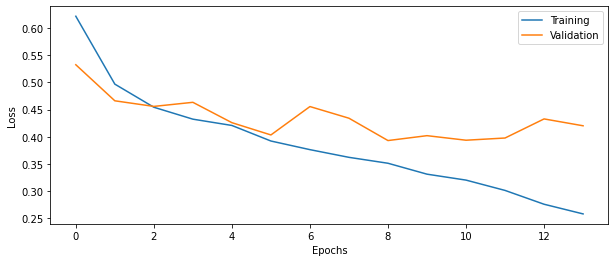

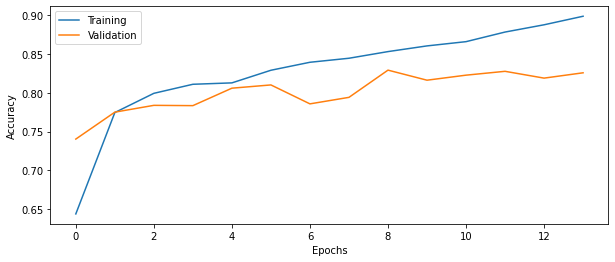

In [17]:
plot_results(history)

## Load the LSTM model from file if available

In [18]:
best_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/TextMining/best_lstm2')
model = best_model

## Use the model to predict on the test set and present results

In [19]:
from sklearn.metrics import classification_report

testpreds = best_model.predict(padded_docs_test)
for i in range(len(testpreds)):
  if testpreds[i]<0.5:
    testpreds[i] = 0
  else:
    testpreds[i] = 1

print(classification_report(labels_test, testpreds))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1133
           1       0.85      0.84      0.85      1489

    accuracy                           0.83      2622
   macro avg       0.82      0.82      0.82      2622
weighted avg       0.83      0.83      0.83      2622



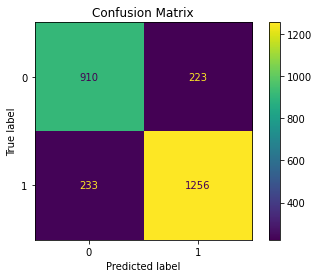

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix(labels_test, testpreds))
disp.plot()
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TextMining/cm_lstm.png')
plt.show()


# **BERT**

## Setting up and fitting the model

In [21]:
# Choose maximum length of a review for the BERT model
MAX_SEQUENCE_LENGTH = 300

# Which pretrained model to use
PRETRAINED_MODEL_NAME = 'distilbert-base-uncased' 

### Set up the DistilBert encoder, encode the three data sets 

In [24]:
def batch_encode(X, tokenizer):
    return tokenizer.batch_encode_plus(
    X,
    max_length=MAX_SEQUENCE_LENGTH, # set the length of the sequences
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True, # add 0 pad tokens to the sequences less than max_length
    return_tensors='tf'
)

In [25]:
tokenizer = DistilBertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [26]:
X_train = batch_encode(df_balanced.ur_prep.values, tokenizer)
X_val = batch_encode(df_val.ur_prep.values, tokenizer)
X_test = batch_encode(df_test.ur_prep.values, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
X_train.values()

dict_values([<tf.Tensor: shape=(13868, 300), dtype=int32, numpy=
array([[  101,  2220,  3229, ...,     0,     0,     0],
       [  101,  3449, 26760, ...,     0,     0,     0],
       [  101,  2220,  3229, ...,     0,     0,     0],
       ...,
       [  101,  4569,  2847, ...,     0,     0,     0],
       [  101,  5128, 12046, ...,     0,     0,     0],
       [  101,  2377,  2986, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(13868, 300), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>])

### Function to create a model

In [63]:
def create_model(max_sequence, model_name, num_labels, trainable):
    bert_model = TFDistilBertModel.from_pretrained(model_name, num_labels=num_labels)
    
    if trainable != True:
          # Make distilbert layers not trainable 
          for layer in bert_model.layers:
            layer.trainable = False

    # Input for the tokens
    input_ids = tf.keras.layers.Input(shape=(max_sequence,), dtype=tf.int32, name='input_ids')

    # Input for the attention mask
    attention_mask = tf.keras.layers.Input((max_sequence,), dtype=tf.int32, name='attention_mask')
    
    # Use previous inputs as BERT inputs:
    output = bert_model([input_ids, attention_mask]).last_hidden_state[:, 0, :]

    if trainable == True:
      # Dropout layer
      output = tf.keras.layers.Dropout(rate=0.15)(output)

      # Dense layer with relu activation
      output = tf.keras.layers.Dense(
          units=768,
          kernel_initializer='glorot_uniform',
          activation='relu',
          name="dense_relu",
          )(output)
      # Dropout layer
      output = tf.keras.layers.Dropout(rate=0.15)(output)

      # Dense layer with relu activation
      output = tf.keras.layers.Dense(
          units=768,
          kernel_initializer='glorot_uniform',
          activation='relu',
          name="dense_relu_2",
          )(output)
      # Dropout layer
      output = tf.keras.layers.Dropout(rate=0.15)(output)

    # Final output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid',
    kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))(output)

    # Final model:
    model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)
    return model

### Create, visualize and compile model

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_distil_bert_model_6 (TFDist  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 ilBertModel)                   ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 300, 768),                                                   
                                 hidden_states=None                                         

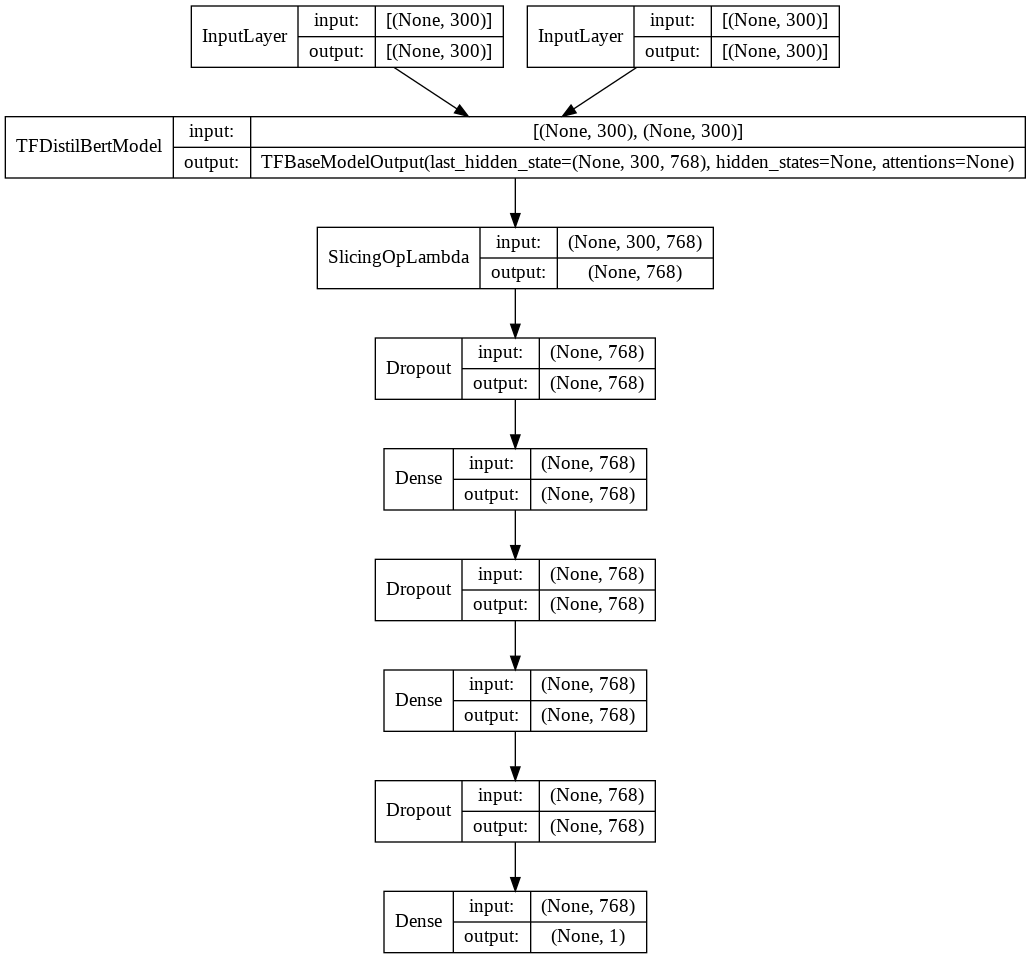

In [64]:
trainable = True
lr = 2e-5 if trainable else 5e-5

bertmodel = create_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, 2, trainable)

bertmodel.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])
bertmodel.summary()
tf.keras.utils.plot_model(bertmodel, to_file='/content/drive/MyDrive/Colab Notebooks/TextMining/bertmodel_plot.png', 
           show_shapes=True, 
           show_layer_names=False)

### Fit the DistilBert model and plot the history

In [65]:
bert_history = bertmodel.fit(x=X_train.values(),
                         y=labels,
                         validation_data=(X_val.values(), labels_val),
                         epochs=20,
                         batch_size=32,
                         callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1), 
                               ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/TextMining/best_bert', monitor='val_accuracy', 
                                               mode='max', save_best_only=True, 
                                               save_weights_only=True, verbose=1)])

Epoch 1/20
434/434 [==============================] - ETA: 0s - loss: 0.4786 - accuracy: 0.7805
Epoch 00001: val_accuracy improved from -inf to 0.77655, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_bert
434/434 [==============================] - 895s 2s/step - loss: 0.4786 - accuracy: 0.7805 - val_loss: 0.5070 - val_accuracy: 0.7765
Epoch 2/20
434/434 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8745
Epoch 00002: val_accuracy improved from 0.77655 to 0.85447, saving model to /content/drive/MyDrive/Colab Notebooks/TextMining/best_bert
434/434 [==============================] - 879s 2s/step - loss: 0.3203 - accuracy: 0.8745 - val_loss: 0.3695 - val_accuracy: 0.8545
Epoch 3/20
434/434 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9313
Epoch 00003: val_accuracy did not improve from 0.85447
434/434 [==============================] - 875s 2s/step - loss: 0.2035 - accuracy: 0.9313 - val_loss: 0.4231 - val_accuracy:

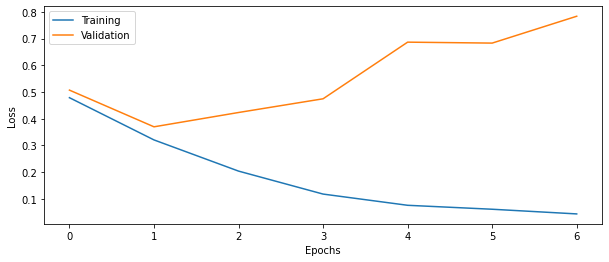

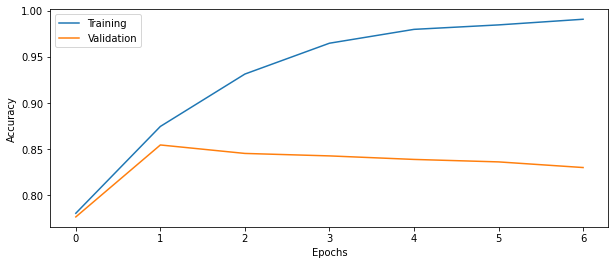

In [66]:
plot_results(bert_history)

## Load the DistilBert model from file, if available

In [67]:
best_bert = create_model(MAX_SEQUENCE_LENGTH, PRETRAINED_MODEL_NAME, 2, trainable)
best_bert.load_weights('/content/drive/MyDrive/Colab Notebooks/TextMining/best_bert')
best_bert.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['accuracy'])

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


## Use the model to predict on the test set and present results

In [68]:
testpreds_bert = best_bert.predict(X_test.values())
for i in range(len(testpreds_bert)):
  if testpreds_bert[i]<0.5:
    testpreds_bert[i] = 0
  else:
    testpreds_bert[i] = 1

print(classification_report(labels_test, testpreds_bert))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      1133
           1       0.82      0.90      0.86      1489

    accuracy                           0.83      2622
   macro avg       0.83      0.82      0.82      2622
weighted avg       0.83      0.83      0.83      2622



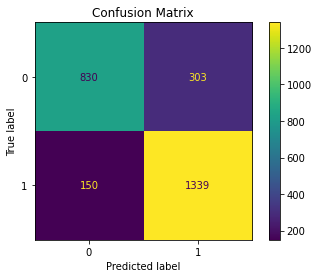

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix(labels_test, testpreds_bert))
disp.plot()
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TextMining/cm_bert.png')
plt.show()


# Manual investigation of some wrongly classified reviews

In [70]:
df_wrong_lstm = df_test[(labels_test!=testpreds[:,0])]
df_wrong_lstm['pred'] = (testpreds[labels_test!=testpreds[:,0]])

df_wrong_bert = df_test[(labels_test!=testpreds_bert[:,0])]
df_wrong_bert['pred'] = (testpreds_bert[labels_test!=testpreds_bert[:,0]])

df_wrong = df_wrong_lstm.merge(df_wrong_bert)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [71]:
df_wrong.shape

(264, 8)

In [72]:
df_wrong = df_wrong.drop(['Unnamed: 0', 'level_0', 'index'], axis=1)
df_wrong = df_wrong.reset_index()
df_wrong = df_wrong.drop(['index'], axis=1)
df_wrong.head()

,title,user_review,user_suggestion,ur_prep,pred
0,Infestation: The New Z,"Pls repair bugs, not only i cant join to some ...",1,pls repair bugs nt join servers join game cra...,0.0
1,WARMODE,"Early Access ReviewPretty much a rip-off CSGO,...",0,early access reviewpretty rip csgo game prett...,1.0
2,Sakura Clicker,"Sakura Clicker made me feel funny, I guess.You...",0,sakura clicker feel funny guess know god damn...,1.0
3,EverQuest II,Product received for freeYou shoudnt judge the...,1,product received freeyou shoudnt judge game p...,0.0
4,Realm of the Mad God,"A year ago, I would tell anyone to stay away f...",1,year ago tell stay away game today point stan...,0.0


In [103]:
df_wrong.groupby('user_suggestion').sample(n=5)

,title,user_review,user_suggestion,ur_prep,pred
31,Fractured Space,Cons: -horrible waiting times (not enought peo...,0,cons waiting times enought people high graphi...,1.0
262,World of Guns: Gun Disassembly,well.. if you plan to go to war this♥♥♥♥♥♥♥s a...,0,plan war s fer starters better world househol...,1.0
58,Heroes & Generals,You can have a panther tank! Yay!You can shoot...,0,panther tank shoot planes panther tank shoot ...,1.0
15,Trove,"This is a really good game, but recently it ha...",0,good game recently taken wrong turn amazing m...,1.0
19,Trove,i played this game for a small bit and what i ...,0,played game small bit got incredibly repetiti...,1.0
239,Fractured Space,"Upon initial download, it did crash repeatedly...",1,initial download crash repeatedly crash mean ...,0.0
151,RaceRoom Racing Experience,I'm not gonna write a review. Instead I'll ask...,1,gon na write review instead ask help big patc...,0.0
52,Yu-Gi-Oh! Duel Links,"this new yu-gi-oh game with new rules , new sh...",1,new yu gi oh game new rules new shity cards s...,0.0
212,RaceRoom Racing Experience,I reccommend this game the paid content is far...,1,reccommend game paid content far better free ...,0.0
14,Elsword,i really dont want to click recommend or not r...,1,nt want click recommend recommend cause game ...,0.0


In [104]:
df_wrong.user_review[151]
#df_wrong.ur_prep[4]


'I\'m not gonna write a review. Instead I\'ll ask for help. After last big patch, I was not able to start a game, so I decided to "delette local content" and reinstall - BUT I NO LONGER HAVE IT IN MY STEAM GAME LIBRARY. !?!?! What to do?  ( I bought a lot of cars and tracks...)'